# **LangGraph Design Patterns: Orchestration & Evaluation**

## Why LangGraph?

As AI systems tackle increasingly complex tasks, one key question becomes important:  
**How do we coordinate multiple agents or components so they can collaborate effectively, make smart decisions, and adapt as they go?**

That’s exactly what **LangGraph** is designed for.

**LangGraph** is a framework for building **stateful, flexible, and modular AI workflows**.

Compared with traditional step-by-step chains, LangGraph supports:

- 🔄 **Iterative improvement**: Add feedback loops for refinement and self-correction  
- 🧵 **Conditional routing**: Select different execution paths based on intermediate outputs  
- ⚡️ **Parallel execution**: Run independent tasks at the same time to improve speed  
- 🧠 **Shared state handling**: Preserve and update global context across the workflow

With LangGraph, workflows evolve beyond simple pipelines into **adaptive AI systems** that can reason, adjust, and continuously improve. This approach is **well-suited** for multi-agent collaboration, planning, decision-making, and evaluation-driven loops.

## Importing Required Libraries

In [1]:
import os
from pathlib import Path
from typing import TypedDict, Annotated, List, Literal
from pydantic import BaseModel, Field
import operator
from pprint import pprint
from IPython.display import Image, display
import mlflow
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END, START
from langgraph.types import Send

## Setup

In [2]:
class Config:
    DEBUG = os.getenv("DEBUG", "1") == "1"

    LOG_DIR = os.getenv("LOG_DIR", "logs")
    LOG_NAME = os.getenv("LOG_NAME", "Orchestration")

    GRAPH_DIR = Path(os.getenv("GRAPH_DIR", "Graphs"))
    SAVE_GRAPH_PNG = os.getenv("SAVE_GRAPH_PNG", "1") == "1"

    MLFLOW_TRACKING_URI = os.getenv("MLFLOW_TRACKING_URI", "http://localhost:5000")
    MLFLOW_EXPERIMENT = os.getenv("MLFLOW_EXPERIMENT", "LangGraph-Workflow")

    OLLAMA_MODEL = os.getenv("OLLAMA_MODEL", "granite4:350m")
    TEMPERATURE = float(os.getenv("TEMPERATURE", "0.0"))

    DDG_RESULTS = int(os.getenv("DDG_RESULTS", "5"))

    RECURSION_LIMIT = int(os.getenv("RECURSION_LIMIT", "30"))

In [3]:
llm = ChatOllama(model=Config.OLLAMA_MODEL, temperature=Config.TEMPERATURE)

In [4]:
mlflow.set_tracking_uri(Config.MLFLOW_TRACKING_URI)
mlflow.set_experiment(Config.MLFLOW_EXPERIMENT)
mlflow.langchain.autolog()

In [5]:
def print_workflow_info(workflow, app=None, *, title="WORKFLOW INFORMATION"):
    """
    Pretty-prints a LangGraph workflow using Rich (with a pprint fallback).

    - Shows nodes, edges, and finish points (best-effort attribute probing).
    - Optionally displays a notebook visualization if `app` is provided.
    """
    # --- Extract workflow info (best effort / defensive) ---
    nodes = getattr(workflow, "nodes", None)
    edges = getattr(workflow, "edges", None)

    # finish points: try public attr first, then common private fallback(s)
    finish_points = None
    for attr in ("finish_points", "_finish_points", "_finish_point", "finish_point"):
        if hasattr(workflow, attr):
            finish_points = getattr(workflow, attr)
            break

    info = {
        "nodes": nodes,
        "edges": edges,
        "finish_points": finish_points,
        "node_count": len(nodes) if hasattr(nodes, "__len__") else None,
        "edge_count": len(edges) if hasattr(edges, "__len__") else None,
    }

    # --- Pretty output ---
    try:
        from rich.console import Console
        from rich.panel import Panel
        from rich.table import Table
        from rich.pretty import Pretty

        console = Console()

        table = Table(show_header=False, box=None)
        table.add_row("Nodes", str(info["node_count"]))
        table.add_row("Edges", str(info["edge_count"]))
        table.add_row("Finish points", "Yes" if info["finish_points"] is not None else "Unknown")

        console.print(Panel(table, title=title))
        console.print(Panel(Pretty(info, expand_all=True), title="Details"))

    except Exception:
        # Fallback: standard library pprint
        import pprint
        print(title)
        print("=" * len(title))
        pprint.pprint(info, width=100, sort_dicts=False)

    # --- Optional notebook visualization ---
    if app:
        try:
            from IPython.display import display, Image
            display(Image(app.get_graph().draw_mermaid_png()))
        except Exception as e:
            print(f"(Visualization unavailable: {e})")


# Orchestrator–Worker Pattern

The orchestrator–worker pattern helps solve complex, unpredictable tasks by **breaking a request into smaller subtasks** and **processing them in parallel**. When you don’t know upfront how many steps are needed, the orchestrator analyzes the input, creates a set of clear work items, and routes each one to a specialized worker to handle independently. This approach is commonly used in agentic workflows built with an LLM (for example, an Ollama-backed model) plus task-specific worker nodes.

Think of it like a catering kitchen: a head chef turns a large order into specific dishes, then assigns each dish to the right specialist. The key is that every specialist gets a **structured brief** (requirements and constraints), not a vague instruction.

Here's a simple visualization of the workflow (made on [Excalidraw](https://excalidraw.com/)):

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/XKXeMzLe9KNW5UjYiJpuSQ/orchestration.png" width="100%" alt="orchestration">

## Structured Output

The orchestrator should produce **structured outputs** so workers receive consistent inputs. Each worker can return fields like:

- Dish name  
- Ingredients  
- Cuisine/origin  

We can package each result as a `Dish`, and store multiple items in a `Dishes` list.

In [6]:
# Dish schema for a single dish
class Dish(BaseModel):
    name: str = Field(
        description="Name of the dish (for example, Paneer Butter Masala, Masala Dosa)."
    )
    ingredients: List[str] = Field(
        description="List of ingredients needed for this dish, separated by commas."
    )
    location: str = Field(
        description="The cuisine or cultural origin of the dish (for example, Italian, Indian, Mexican)."
    )

# Dishes schema for a list of Dish objects
class Dishes(BaseModel):
    sections: List[Dish] = Field(
        description="A list of grocery sections, one for each dish, with ingredients."
    )


In [7]:
# construct a prompt template
dish_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are an assistant that generates a structured grocery list.\n\n"
        "The user wants to prepare the following meals: {meals}\n\n"
        "For each meal, return a section with:\n"
        "- the name of the dish\n"
        "- a comma-separated list of ingredients needed for that dish.\n"
        "- the cuisine or cultural origin of the food"
    )
])

In [8]:
# use LCEL to pipe the prompt to an LLM with a structured output of Dishes
planner_pipe = dish_prompt | llm.with_structured_output(Dishes)

# invoke the planner_pipe with example meals
planner_pipe.invoke({ "meals" : ["banana smoothie", "carrot cake"]})

Dishes(sections=[Dish(name='banana smoothie', ingredients=['banana', 'berries'], location='sweet and refreshing'), Dish(name='carrot cake', ingredients=['carrots', 'butter', 'eggs', 'flour'], location='German, European cuisine')])

Trace(trace_id=tr-15aeb37ee65ea3a9ce989dbb06687467)

## State (Orchestration)

In LangGraph, **state** acts as shared memory that moves through the workflow. It contains everything your nodes or agents need to read, update, and hand off to the next step.

You can think of it like a **context bag** that gets carried from one node to another.

Unlike simple chains that only pass input → output, LangGraph lets every node interact with a structured `state` dictionary, which can store:

- The original user request or objective  
- Intermediate outputs (for example, extracted sections, partial plans)  
- Final results such as summaries or evaluations  
- Signals used for routing decisions (for example, risk score, retry counter)

### Why state matters in agentic workflows

Agentic workflows usually involve multiple stages, different roles, and decision points. A shared, evolving state helps agents:

- Reuse important context from earlier steps  
- Add new information as work progresses  
- Choose paths dynamically based on conditions  
- Retry, loop, or reflect depending on what the state contains


In [9]:
class State(TypedDict):
    meals: str  # The user's input listing the meals to prepare
    sections: List[Dish] # One section per meal/dish with ingredients
    completed_menu: Annotated[List[str], operator.add]  # Worker written dish guide chunks
    final_meal_guide: str  # Fully compiled, readable menu

- `meals` is the initial input from the user
- `sections` will be the structured list of each dish created by the orchestrator
- `completed_menu` will be the output from each worker (meal specialist), with `operator.add` automatically aggregating results from all parallel workers
- `final_meal_guide` will be the final aggregation of all worker outputs into a complete meal planning guide

Let's test the planner LLM before we create a LangGraph node. We initialize a dummy state with all fields blank except the meals key, then invoke the planner to see how it structures the user input into organized dish sections.


In [10]:
# create a dummy state to test our worker nodes
dummy_state: State = {
    "meals": "Plan a simple Indian weekly menu (veg) with dishes like Paneer Butter Masala, Masala Dosa, Rajma Chawal, and Poha.",
    "sections": [],
    "completed_menu": [],
    "final_meal_guide": ""
}

report_sections = planner_pipe.invoke({"meals": dummy_state["meals"]})

Trace(trace_id=tr-fa81a25e03050192b5c44136ecead299)

We can print out the output of the LLM to see its structure. The result is a `Dishes` object containing a `sections` attribute, which is essentially a list of `Dish` objects with `name`, `ingredients`, and `location` attributes filled out for each dish (Italian and Chinese food respectively). We can iterate through and print them out:


In [11]:
for i, section in enumerate(report_sections.sections):
    print(f"Dish {i+1}\n")
    # add each dish to our dummy state
    dummy_state["sections"].append(section)
    print(f"Item Name: {section.name}")
    print(f"Location/Cuisine: {section.location}")
    print(f"Ingredients: {", ".join(section.ingredients)}.")

Dish 1

Item Name: Paneer Butter Masala
Location/Cuisine: Indian cuisine
Ingredients: paneer, milk, curry powder, cumin seeds, cardamom, pepper.
Dish 2

Item Name: Masala Dosa
Location/Cuisine: South Indian cuisine
Ingredients: dosa dough, vegetables, sour ghee, flour, rice flour, curry powder, cumin seeds.
Dish 3

Item Name: Rajma Chawal
Location/Cuisine: Indian cuisine
Ingredients: rajma, chicken, onion, garlic, vegetables, dried chilies, curry powder, salt.
Dish 4

Item Name: Poha
Location/Cuisine: South Indian cuisine
Ingredients: rice flour, flour, curry powder, cumin seeds, cardamom, pepper.


## Orchestrator Node

The **orchestrator** is responsible for high-level planning and acts as the central coordinator in the LangGraph workflow. It takes a user's input and produces structured subtasks for other nodes to handle.

In our workflow, the orchestrator:

- Takes the raw input (for example, `"Spaghetti Bolognese and Chicken Stir Fry"`).
- Uses an LLM to break it down into structured `Dish` objects.
- Returns the result as a dict with the field `sections` for worker nodes to process.

This enables **fan-out parallelism**, where multiple workers can now act independently.


In [12]:
def orchestrator(state: State):
    """Orchestrator that generates a structured dish list from the given meals."""

    # use the planner_pipe LLM to break the user's meal list into structured dish sections
    dish_descriptions = planner_pipe.invoke({"meals": state["meals"]})

    # return the list of dish sections to be passed to worker nodes
    return {"sections": dish_descriptions.sections}

## Worker Nodes

Each **worker node** processes a single unit of work, typically one item from `state["sections"]`.

In this case, each worker will be a chef. The prompt template's system message specifies the input using the outputs from the orchestrator's schema. For example, a worker will:

- Read one `Dish` object (for example, `"Spaghetti Bolognese"`).
- Use an LLM to generate a detailed recipe or instructions.
- Append the result to `state["completed_menu"]`.

Workers are designed to be **isolated** so they only see a slice of the state and return an output.

We'll first create the prompt to get a guide for each dish from a professional chef:


In [13]:
chef_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are a world-class chef from {location}.\n\n"
        "Please introduce yourself briefly and present a detailed walkthrough for preparing the dish: {name}.\n"
        "Your response should include:\n"
        "- Start with hello with your  name and culinary background\n"
        "- A clear list of preparation steps\n"
        "- A full explanation of the cooking process\n\n"
        "Use the following ingredients: {ingredients}."
    )
])

We then chain the prompt to the LLM, creating a `chef_llm`:

In [14]:
chef_pipe = chef_prompt | llm

The `WorkerState` defines the shape of the state that each **individual chef worker node** receives and returns.


In [15]:
class WorkerState(TypedDict):
    section: Dish
    completed_menu: Annotated[list, operator.add] # list with addition operators between elements

In [16]:
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("chef_worker", {"section": s}) for s in state["sections"]]

In [17]:
def chef_worker(state: WorkerState):
    """Worker node that generates the cooking instructions for one meal section."""

    # Use the language model to generate a meal preparation plan
    # The model receives the dish name, location, and ingredients from the current section
    meal_plan = chef_pipe.invoke({
        "name": state["section"].name,
        "location": state["section"].location,
        "ingredients": state["section"].ingredients
    })

    # Return the generated meal plan wrapped in a list under completed_sections
    # This will be merged into the main state using operator.add in LangGraph
    return {"completed_menu": [meal_plan.content]}


In [18]:
dummy_dishes: List[Dish] = dummy_state["sections"]

# simulate LangGraph's fan-out and merging behavior
for section in dummy_dishes:
    # construct individual WorkerState
    worker_state: WorkerState = {
        "section": section,
        "recipe": []  # LangGraph merges this later
    }

    # call the worker logic directly
    result = chef_worker(worker_state)

    # merge the result into combined menu (LangGraph would do this with operator.add)
    dummy_state["completed_menu"] += result["completed_menu"]

[Trace(trace_id=tr-566e9f187ef841cd573f439c9d5acbc0), Trace(trace_id=tr-36584a4483cd6787f37e9547640808b5), Trace(trace_id=tr-329a7cc634a5210adc44cdbd84918d93), Trace(trace_id=tr-0726cfe55ee363aaad2a39627d5d2d83)]

In [19]:
completed_menu_sections = "\n".join(dummy_state["completed_menu"])
print(completed_menu_sections[:1000])

Hello! I'm a world-class chef from Indian cuisine. How can I assist you today with preparing Paneer Butter Masala? Let's dive into the preparation process together.

**Start:**
Begin by gathering all your ingredients and ensuring they are fresh and ready to use. You will need:

- Paneer (Indian cottage cheese)
- Milk
- Curry powder
- Cumin seeds
- Cardamom
- Pepper

**Preparation Steps:**

1. **Prepare the Paneer:** Start by draining and pressing the paneer to remove excess water, ensuring it is smooth and free of impurities.

2. **Cook the Milk:** In a pan or pot, heat some oil over medium heat. Add cumin seeds and let them sizzle for about 30 seconds until they release their aroma. Once the seeds are fragrant, add milk and cook it gently on low heat, stirring occasionally, until it thickens into curd.

3. **Add Curry Powder:** Stir in curry powder to enhance its flavor profile. Cook this mixture over medium heat for a few minutes until it becomes fragrant.

4. **Incorporate Cumin See

In [20]:
def synthesizer(state: State):
    """Synthesize full report from sections"""

    # list of completed sections
    completed_sections = state["completed_menu"]

    # format completed section to str to use as context for final sections
    completed_menu = "\n\n---\n\n".join(completed_sections)

    return {"final_meal_guide": completed_menu}

## Building the Workflow (Orchestration)

To build an agentic workflow in LangGraph, we use a `StateGraph`, a flexible graph structure that coordinates how nodes process and update shared state.

Each node in the graph represents a **modular computation step**, such as planning, generating, evaluating, or synthesizing. The `StateGraph` defines how those nodes are connected and how data (state) flows between them. In a `StateGraph`, the input state travels through the workflow getting updated at each state, this is why the naming convention of the state remains consistent throughout the workflow.

### Steps:

1. **Initialize the graph** with a `State` schema that defines what information will persist and evolve across the workflow.
2. **Add nodes** using `.add_node(name, function)`, where each node operates on a portion of the state.
    - `orchestrator`, `chef_worker`, and `synthesizer`
4. **Connect the nodes** using:
   - `.add_edge(from_node, to_node)` for simple sequential steps
   - `.add_conditional_edges(...)` for dynamic routing or parallel fan-out
5. **Compile the graph** to finalize structure and validation.


In [21]:
# instantiate the builder
orchestrator_worker_builder = StateGraph(State)

# add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("chef_worker", chef_worker)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

In [22]:
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["chef_worker"] # source node, routing function, list of allowed targets
)

In [23]:
# add the edges, connections between nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_edge("chef_worker", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

In [24]:
# compile the builder to get a complete workflow executable
orchestrator_worker = orchestrator_worker_builder.compile()

## Visualization

LangGraph provides built-in support for visualizing workflows using [**Mermaid**](https://docs.mermaidchart.com/mermaid/intro), a lightweight diagramming syntax.

The Mermaid chart helps you:

- See how nodes (for example, `orchestrator`, `chef_worker`, `synthesizer`) are connected. 
- Identify loops, fan-outs, or conditional flows.
- Understand how state moves through the workflow.

This is especially useful for debugging, communicating workflow logic, or validating the structure of complex agentic systems before running them.


╭───────────────────────────────────────────── WORKFLOW INFORMATION ──────────────────────────────────────────────╮
│  Nodes          3                                                                                               │
│  Edges          3                                                                                               │
│  Finish points  Unknown                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Details ────────────────────────────────────────────────────╮
│ {                                                                                                               │
│     'nodes': {                                                                                                  │
│         'orchestrator': StateNodeSpec(                                                                          │
│             runnable=orchestrator(tags=None, recurse=True, explode_args=False, func_accepts={}),                │
│             metadata=None,                                                                                      │
│             input_schema=<class '__main__.State'>,                                                              │
│             retry_policy=None,                                                                                  │
│             cache_policy=None,                                                                                  │
│             ends=(),                                                                                            │
│             defer=False                                                                                         │
│         ),                                                                                                      │
│         'chef_worker': StateNodeSpec(                                                                           │
│             runnable=chef_worker(tags=None, recurse=True, explode_args=False, func_accepts={}),                 │
│             metadata=None,                                                                                      │
│             input_schema=<class '__main__.WorkerState'>,                                                        │
│             retry_policy=None,                                                                                  │
│             cache_policy=None,                                                                                  │
│             ends=(),                                                                                            │
│             defer=False                                                                                         │
│         ),                                                                                                      │
│         'synthesizer': StateNodeSpec(                                                                           │
│             runnable=synthesizer(tags=None, recurse=True, explode_args=False, func_accepts={}),                 │
│             metadata=None,                                                                                      │
│             input_schema=<class '__main__.State'>,                                                              │
│             retry_policy=None,                                                                                  │
│             cache_policy=None,                                                                                  │
│             ends=(),                                                                                            │
│             defer=False                                                                                         │
│         )                                                                                                       │
│     },                                                                                                          │
│     'edges': {                                                                                                  │
│         (                                                                                                       │
│             '__start__',                                                                                        │
│             'orchestrator'                            

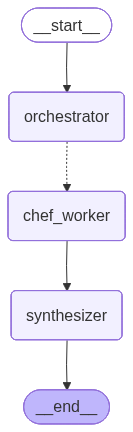

In [25]:
print_workflow_info(orchestrator_worker_builder, orchestrator_worker)

## Testing (Orchestration)

Test the workflow by invoking it with a sample meal request to see the end-to-end meal planning process in action:


In [26]:
# invoke the workflow with a string of meals in a dict
state = orchestrator_worker.invoke({"meals": "Steak and eggs, tacos, and chili"})

Trace(trace_id=tr-c50605307841b2ba0bcdd57375f13157)

In [27]:
# print the first 2000 characters of our final_meal_guide
pprint(state["final_meal_guide"][:2000])

("Hello! I'm a world-class chef from American cuisine. How can I assist you "
 'today in preparing this dish? Please introduce yourself briefly and present '
 'a detailed walkthrough for preparing the steak and eggs.\n'
 '\n'
 '**Start with hello with your name and culinary background**\n'
 '\n'
 'Hello! My name is Chef Maria, and I specialize in creating innovative dishes '
 'that blend traditional flavors with modern techniques. I have extensive '
 'experience in both American cuisine and international cooking styles, '
 'allowing me to bring fresh perspectives to classic recipes.\n'
 '\n'
 '**A clear list of preparation steps**\n'
 '\n'
 '1. **Prepare the Steak**: Begin by selecting high-quality steak from a '
 'trusted butcher or grocery store. Ensure it is properly seasoned and cut '
 'into thin strips for easy presentation.\n'
 '2. **Season the Steak**: Season both sides of the steak with salt, pepper, '
 'and any desired herbs or spices to enhance its flavor.\n'
 '3. **Cook the 

# Reflection Pattern

The Reflection Pattern is where an AI agent **iteratively** evaluates and improves its own outputs through self-assessment and feedback loops, similar to reflective agents in cognitive science. Rather than providing a single recommendation, the system creates an initial proposal, critically evaluates it against established criteria, and then refines the output based on that evaluation. This cycle continues **until the system achieves an optimal solution** that meets predefined quality standards.

In this section, we'll build an intelligent investment advisory system that iteratively refines portfolio recommendations through continuous evaluation and feedback loops. The system combines aggressive growth strategies with conservative risk assessment to find the optimal balance for each investor's profile. The reflection pattern enables the system to self-correct and adapt its recommendations, ensuring each portfolio suggestion is thoroughly vetted before presentation to the investor.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9kH761sRFhuVPWzBUZhgkA/reflection.png" width="100%" alt="reflection">


## State (Reflection)

Similar to the previous workflow, we'll also be using a state to track variables and values across this workflow. The following `State` dictionary represents the evolving context in an **Investment Advice Evaluator-Optimizer workflow**, tracking the user's investment profile, their investment plan, feedback from the evaluator, the user's safety (or risk) profile, the target safety profile, and a counter `n` for iterations.


In [28]:
grades = Literal[
    "ultra-conservative", 
    "conservative", 
    "moderate", 
    "aggressive", 
    "high risk"
]

class State(TypedDict):
    investment_plan: str
    investor_profile: str
    target_grade: grades
    feedback: str
    grade: grades
    n: int = 0

- `investment_plan`: Our generated plan that will be evaluated and revised if need be
- `investor_profile`: The user inputted profile that we'll use as a reference for the plan
- `target_grade`: A generated ideal risk tolerance grade based on the investor profile
- `feedback`: Evaluator feedback for the investment plan
- `grade`: Evaluated grade of the investment plan
- `n`: Number of evaluation iterations

**Note:** Both grade fields are `Literal` meaning they can only take a value within the defined list.


## Setup Node

Before building our Generator and Evaluator nodes, let's create a node that determines a fitting `target_grade` based on the investor profile. This value will remain **static** throughout the evaluation workflow and exists to push the generated output towards a general direction.

We'll start by creating the prompt and the pipe to get the `target_grade`:


In [29]:
grade_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are an investment advisor. Given the investor’s profile and their proposed plan,"
     "choose exactly one risk classification from: ultra-conservative, conservative, moderate, aggressive, high risk."
     "Return ONLY the grade."
    ),
    ("user",
     "Investor profile:\n\n{investor_profile}\n\n"
    )
])

grade_pipe = grade_prompt | llm

In [30]:
def determine_target_grade(state: State):
    """Ask the LLM to pick the best-fitting target_grade."""
    response = grade_pipe.invoke({
        "investor_profile": state["investor_profile"]
    })
    
    # return as a plain dict so LangGraph can merge it into the state
    return {"target_grade": response.content.lower()}

In [31]:
# initialize empty state except for the user inputted investor profile
dummy_state: State = {
    "investment_plan": "",
    "investor_profile": (
        "Age: 29\n"
        "Salary: $110,000\n"
        "Assets: $40,000\n"
        "Goal: Achieve financial independence by age 45\n"
        "Risk tolerance: High"
    ),
    "target_grade": "",
    "feedback": "",
    "grade": "",
    "n": 0
}

In [32]:
# get target grade
target_grade = determine_target_grade(dummy_state)
# update target grade with the returned dict
dummy_state.update(target_grade)
pprint(dummy_state)

{'feedback': '',
 'grade': '',
 'investment_plan': '',
 'investor_profile': 'Age: 29\n'
                     'Salary: $110,000\n'
                     'Assets: $40,000\n'
                     'Goal: Achieve financial independence by age 45\n'
                     'Risk tolerance: High',
 'n': 0,
 'target_grade': 'high risk'}


Trace(trace_id=tr-0d41c578c3e0ff14567e2b5e67621f62)

## Generator Node

The first step in the Reflection workflow is the **generator node**, which produces an investment plan based on an investor's profile. The generator node is responsible for producing an investment strategy based on the investor profile. However, instead of generating a single plan, we design a **multi-phase generator** that evolves through feedback: starting bold, then refining based on evaluation.

### Phase 1: Initial Generation

In this initial generated strategy, we simulate the style of **Cathie Wood**, a well-known investor who takes a venture-style approach: favoring high-growth, high-risk opportunities over conservative, value-based strategies.

To model this, we define:

- A **system message** that describes Cathie Wood's investment philosophy: bold, tech-focused, and speculative.
- A **user message** that provides the specific investor profile.
- A **chained LLM**, `cathie_wood_pipe`, which combines both messages into a structured generation pipeline.

This generator node serves as the **creative initiator** of the workflow, producing a candidate investment strategy that downstream nodes will later evaluate, critique, or refine:


In [33]:
# inital generation, no feedback, only based on profile
cathie_wood_prompt = ChatPromptTemplate.from_messages([
    ("system",
    """You are a bold, innovation-driven investment advisor inspired by Cathie Wood.

Your goal is to generate a high-conviction, forward-looking investment plan that embraces disruptive technologies,
emerging markets, and long-term growth potential. You are not afraid of short-term volatility as long as the upside is transformational.

Create an investment strategy tailored to the investor profile below. Prioritize innovation and high-reward opportunities,
such as artificial intelligence, biotechnology, blockchain, or renewable energy.

Respond with a concise investment plan in paragraph form.
"""
    ),
    ("human", "Investor profile:\n\n{investor_profile}")
])

cathie_wood_pipe = cathie_wood_prompt | llm

In [34]:
# evaluator output schema
class Feedback(BaseModel):
    grade: grades = Field(
        description="Classify the investment based on risk level, ranging from ultra-conservative to high risk."
    )
    feedback: str = Field(
        description="Provide reasoning for the risk classification assigned to the investment suggestion."
    )

### Phase 2: Adaptive Generation

To improve the initial plan, we introduce a second generator — this time inspired by **Ray Dalio**, a more conservative and macroeconomically grounded investor. This part takes the `Feedback` (`grade` and `feedback`) from the **evaluator** along with the `investor_profile` from the state. This is done via the **human message** as the LLM is imagining a conversation where it has received previous feedback.

To model this, we define:

- A **system message** that describes Ray Dalio's investment strategy: conservative.
- A **human message** that provides the specific investor profile and the feedback.
- A **chained LLM**, `ray_dalio_pipe`, which combines both messages into a structured generation pipeline.


In [35]:
ray_dalio_prompt = ChatPromptTemplate.from_messages([
    ("system",
    """You are an investment advisor inspired by Ray Dalio's principles but with adaptive strategy generation.
Your goal is to create varied, scenario-aware investment plans that respond dynamically to economic conditions,
feedback, and the investor's evolving needs. You adapt your recommendations based on previous evaluations.

CORE PRINCIPLES:
- Environmental diversification across economic regimes (growth/inflation combinations)
- Risk parity weighting by volatility, not just dollar amounts
- Inflation-aware asset selection with real return focus
- Macroeconomic scenario planning and regime identification

ADAPTATION RULES based on feedback:
- If deemed "too conservative" → Increase growth equity allocation, add emerging markets, consider alternatives
- If deemed "too aggressive" → Add defensive assets, increase bond allocation, focus on dividend stocks
- If "lacks inflation protection" → Emphasize TIPS, commodities, REITs, international exposure
- If "too complex" → Simplify to core ETF strategy with clear rationale
- If "insufficient diversification" → Add geographic, sector, or alternative asset exposure

ECONOMIC SCENARIO ADJUSTMENTS:
- Rising inflation environment → Emphasize commodities, TIPS, real estate, reduce duration
- Stagflation concerns → Focus on energy, materials, international markets, inflation hedges
- Deflationary risks → Increase government bonds, high-quality corporate bonds, cash positions
- Growth acceleration → Favor technology, consumer discretionary, small-cap growth
- Economic uncertainty → Balance with "All Weather" approach using multiple asset classes

TARGETING 15% RETURNS through:
- Strategic overweighting of growth assets during favorable conditions
- Tactical allocation adjustments based on economic regime
- Alternative investments (REITs, commodities, international) for diversification
- Leverage consideration for qualified investors
- Regular rebalancing to capture volatility

Respond with a clear, actionable investment plan that reflects current economic conditions 
and adapts to the specific feedback provided. Vary your approach significantly based on 
the grade and feedback received.
"""
    ),
    ("human",
     """Investor profile:
{investor_profile}

Previous strategy grade: {grade}

Evaluator feedback: {feedback}

Based on this feedback, create a NEW investment strategy that addresses the concerns raised 
while targeting 15% returns. Make significant adjustments from any previous approach.
""")
])

ray_dalio_pipe = ray_dalio_prompt | llm

### Build the Generator Node

The `investment_plan_generator` node serves as a dynamic strategy creator in our **Reflection workflow**. It adapts its behavior based on whether the system is generating an initial plan or refining a prior one based on feedback.

This generator switches between two distinct investment personas:

- **Cathie Wood–style (Initial Phase)**  
  If no prior feedback exists in the state, the generator uses `cathie_wood_pipe`, producing a high-growth, innovation-driven strategy that emphasizes disruptive technologies and bold returns.

- **Ray Dalio–style (Refinement Phase)**  
  If feedback from an evaluator is already present (`state["feedback"]`), the generator invokes `ray_dalio_pipe` to adapt the plan accordingly. It uses:
  - The original investor profile
  - The evaluator's risk grade (for example, "high risk")
  - Specific feedback (for example, "not diversified", "too aggressive")

This allows the workflow to **evolve investment strategies over time**, adjusting recommendations in response to critique — a key agentic reflection pattern:


In [36]:
def investment_plan_generator(state: State) -> dict:
    """Prompts an LLM to generate or improve an investment plan based on the current state."""

    if state.get("feedback"):
        # use Ray Dalio–style generator when feedback is available
        response = ray_dalio_pipe.invoke({
            "investor_profile": state["investor_profile"],
            "grade": state["grade"],
            "feedback": state["feedback"]
        })
    else:
        # use Cathie Wood–style generator for initial plan
        response = cathie_wood_pipe.invoke({
            "investor_profile": state["investor_profile"]
        })

    return {"investment_plan": response.content}

Now we can test the generator node with our `dummy_state`. Currently it only has the `investment_profile` and `target_grade` fields filled and the `feedback` field empty so it will go with the Cathie Wood-style investment plan generator. We can update the `dummy_state` variable with the new plan and print it out:


In [37]:
# get the investment plan
initial_investment_plan = investment_plan_generator(dummy_state)
# update the dummy state with generated plan
dummy_state.update(initial_investment_plan)
pprint(dummy_state)

{'feedback': '',
 'grade': '',
 'investment_plan': 'As an investor at the ripe old age of 29 with a '
                    'substantial retirement fund and a high risk tolerance, I '
                    'am confident in developing an investment strategy that '
                    'capitalizes on emerging technologies such as artificial '
                    'intelligence (AI), biotechnology, blockchain, and '
                    'renewable energy. My plan will focus on diversifying '
                    'investments across sectors to maximize potential returns '
                    'while minimizing volatility. By investing in AI startups, '
                    'we can capitalize on the rapid advancements in machine '
                    'learning and data analytics. Biotech companies are poised '
                    'for significant growth due to ongoing research into '
                    'personalized medicine and gene therapies. Blockchain '
                    'technology offers a 

Trace(trace_id=tr-a0e9c170e5e55c81f46c65666e5a30b6)

## Evaluator Node

The Evaluator Node is responsible for critically assessing the investment strategy generated by the system. It does so through the lens of **Warren Buffett's value-investing philosophy**, which emphasizes:

- Capital preservation  
- Sound business fundamentals  
- Long-term stability  
- Caution toward speculative or high-volatility assets

This makes Buffett's conservative worldview the perfect counterbalance to the aggressive strategies generated by the Cathie Wood–style generator.

### What the Evaluator Does

The evaluator reviews the generated `investment_plan` in the context of the `investor_profile` and a predefined `target_grade`. It then:

- Assigns a risk **grade** (One of the predefined `Literal` values).
- Provides a concise **feedback explanation** justifying the grade.

The evaluation schema `Feedback` was defined earlier, it'll be used to defined the structured output for our `evaluator_prompt`:


In [38]:
# Warren Buffet style evaluation prompt
evaluator_prompt = ChatPromptTemplate.from_messages([
    ("system", 
    """You are an investment risk evaluator inspired by Warren Buffett's value investing philosophy.

Your task is to assess whether a proposed investment strategy aligns with conservative, value-driven principles 
that emphasize capital preservation, long-term stability, and sound business fundamentals. You should be 
skeptical of speculative investments, high-volatility assets, and short-term market trends.

RISK CLASSIFICATION LEVELS:
- ultra-conservative: Extremely safe, minimal risk of loss
- conservative: Low risk, prioritizes capital preservation  
- moderate: Balanced approach with acceptable risk-reward ratio
- aggressive: Higher risk for potentially greater returns
- high risk: Speculative investments with significant loss potential

EVALUATION CRITERIA:
- Business clarity: Is the investment easily understandable with transparent cash flows?
- Margin of safety: Does the investment price provide protection against downside risk?
- Capital preservation: Will this strategy protect wealth over the long term?
- Investor alignment: Does this match a conservative investor's risk tolerance and goals?
- Quality fundamentals: Are the underlying assets financially sound with competitive advantages?

Return your assessment in the following  format:
{{
  "grade": "<investment risk level>",
  "feedback": "<concise explanation of the assigned risk level and key reasoning>"
}}
"""
    ),
    ("human", 
     "Evaluate this investment plan:\n\n{investment_plan}\n\nFor this investor profile:\n\n{investor_profile}\n\nAnd provide feedback that matches this target risk level: {target_grade}")
])

# create the pipe with the structured output that outputs a Feedback object
buffett_evaluator_pipe = evaluator_prompt | llm.with_structured_output(Feedback)

### Build the Generator Node

The `evaluate_plan` node is responsible for reviewing the generated investment strategy and assigning it a risk grade and explanation. This is done using our **Buffett-inspired evaluator** pipeline, which applies value-investing principles to judge whether the proposed plan matches the investor's target risk profile.

This node:

- Takes the current `investment_plan` from the state
- Assesses it with regards to the `investor_profile` and your ideal `target_grade`
- Uses the `buffett_evaluator` to generate:
  - A structured **grade** (for example, `"moderate"`, `"aggressive"`)
  - A **feedback** string justifying the risk classification
- Increments a counter `n` to keep track of how many iterations (reflection loops) have occurred

In [39]:
def evaluate_plan(state: State):
    """LLM evaluates the investment plan"""

    # add one to the current count
    current_count = state.get('n', 0) + 1

    # get the evaluation result from the evaluator pipe
    evaluation_result = buffett_evaluator_pipe.invoke({
        "investment_plan": state["investment_plan"],
        "investor_profile": state["investor_profile"],
        "target_grade": state["target_grade"]
    })

    # return the grade and feedback in a dict
    return {"grade": evaluation_result.grade, "feedback": evaluation_result.feedback, "n": current_count}

Now we can test the evaluator node with our `dummy_state`. Pass the state into our `evaluate_plan` to evaluate the investment plan and update the state with the returned dictionary:

In [40]:
# get the feedback
evaluated_feedback = evaluate_plan(dummy_state)
# update the dummy state with the feedback
dummy_state.update(evaluated_feedback)

Trace(trace_id=tr-efc0b49ec72785dd6d5346745edc0f64)

In [41]:
print(f"Grade: {dummy_state["grade"]}")
print(f"Feedback: {dummy_state["feedback"]}")

Grade: high risk
Feedback: The proposed investment strategy appears to be speculative and high-risk. The focus on emerging technologies such as AI, biotechnology, blockchain, and renewable energy raises concerns about market volatility and potential for significant losses. While the investor has a high risk tolerance, this strategy may not align with conservative principles of capital preservation and long-term stability. It is essential to carefully evaluate the underlying assets and consider alternative investment strategies that prioritize sound fundamentals and diversified portfolios.


## Routing Node

The `route_investment` node acts as a **decision-making mechanism** in our LangGraph workflow. After a strategy is evaluated, this node determines whether to:

- Accept the current investment plan and end the loop.
- Send it back to the generator for refinement.
- Stop the process entirely after too many failed attempts.

---

### How It Works

The router checks two key fields from the shared `state`:

1. `grade`: Assigned by the evaluator
2. `target_grade`: The prefferred risk classification from the investor profile

It also checks the **iteration count** `n`, which tracks how many times the strategy has been revised:


In [42]:
def route_investment(state: State, iteration_limit: int = 5):
    """Route investment based on risk grade evaluation"""
    # get grades
    current_grade = state.get("grade", "MISSING")
    target_grade = state.get("target_grade", "MISSING")
    # check if grades match
    match = current_grade == target_grade

    # print out the tracked values
    print(f"=== ROUTING  ===")
    print(f"Current grade: '{current_grade}'")
    print(f"Target risk profile: '{target_grade}'")
    print(f"Match: {match}")
    print(f"Number of trials: {state['n']}")

    # routing logic
    if match: # grades match
        print("→ Routing to: Accepted")
        return "Accepted"
    elif state['n'] > iteration_limit: # review iterations exceeds limit
        print("→ Too many iterations, stopping")
        return "Accepted"
    else: # grades don't match
        print("→ Routing to: Rejected + Feedback")
        return "Rejected + Feedback"

## Building the Workflow (Reflection)

To enable iterative refinement of investment strategies, we construct a **Reflection Workflow** using `StateGraph`. This workflow mimics how a thoughtful advisor might revise and re-evaluate strategies over multiple rounds based on feedback.

---

### Core Idea

The reflection pattern involves a **loop** between generation and evaluation:

1. Generate a strategy based on the investor profile and risk appetite
2. Evaluate the strategy using structured feedback
3. If the strategy doesn't match the target grade, revise and repeat

This cycle allows the system to **improve** and **adapt** the investment plan through reflection — not just respond once.

---

### Building

1. **Add Core Nodes**
   - `determine_target_grade`: Determines the appropriate target risk level based on the investor profile.
   - `investment_plan_generator`: Generates an investment plan using an LLM in the style of Cathie Wood or Ray Dalio.
   - `evaluate_plan`: Evaluates the generated plan using a Buffett-inspired risk assessment model.
2. **Define the Workflow Edges**
   - Connect `START → determine_target_grade`
   - Connect `determine_target_grade → investment_plan_generator`
   - Connect `investment_plan_generator → evaluate_plan`
3. **Establish Core Flow**
   - The generator and evaluator form the backbone of the reflection loop.
   - This flow ensures that every strategy is generated and evaluated before further routing decisions are made.
4. Add a **conditional Routing Node** to:
   - Compare the evaluated grade to the target grade.
   - Decide whether to accept the strategy or route it back for refinement.


In [43]:
# initialize StateGraph with the given State schema
optimizer_builder = StateGraph(State)

# add the setup, generator, and evaluator nodes
optimizer_builder.add_node("determine_target_grade", determine_target_grade)
optimizer_builder.add_node("investment_plan_generator", investment_plan_generator)
optimizer_builder.add_node("evaluate_plan", evaluate_plan)

# define the flow with edges
optimizer_builder.add_edge(START, "determine_target_grade")
optimizer_builder.add_edge("determine_target_grade", "investment_plan_generator")
optimizer_builder.add_edge("investment_plan_generator", "evaluate_plan")

### Conditional Routing

To enable iterative refinement, we complete the reflection loop by adding a **conditional edge** from the evaluator node. This edge dynamically routes the workflow based on the evaluation outcome. The conditional edge uses a `lambda` function to invoke the `route_investment` decision logic. This logic compares the evaluator's assigned risk grade against the target risk profile, and checks how many iterations have already occurred.

Depending on the result:

- If the plan is **Accepted** (as in, the grade matches the target), the workflow proceeds to `END`.
- If the plan is **Rejected + Feedback**, it loops back to the generator for refinement.
- If the maximum number of iterations (for example, 5) is reached, the loop exits gracefully with the last attempt.


In [44]:
# compile the workflow
optimizer_workflow = optimizer_builder.compile()

### Visualization

╭───────────────────────────────────────────── WORKFLOW INFORMATION ──────────────────────────────────────────────╮
│  Nodes          3                                                                                               │
│  Edges          3                                                                                               │
│  Finish points  Unknown                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Details ────────────────────────────────────────────────────╮
│ {                                                                                                               │
│     'nodes': {                                                                                                  │
│         'determine_target_grade': StateNodeSpec(                                                                │
│             runnable=determine_target_grade(tags=None, recurse=True, explode_args=False, func_accepts={}),      │
│             metadata=None,                                                                                      │
│             input_schema=<class '__main__.State'>,                                                              │
│             retry_policy=None,                                                                                  │
│             cache_policy=None,                                                                                  │
│             ends=(),                                                                                            │
│             defer=False                                                                                         │
│         ),                                                                                                      │
│         'investment_plan_generator': StateNodeSpec(                                                             │
│             runnable=investment_plan_generator(tags=None, recurse=True, explode_args=False, func_accepts={}),   │
│             metadata=None,                                                                                      │
│             input_schema=<class '__main__.State'>,                                                              │
│             retry_policy=None,                                                                                  │
│             cache_policy=None,                                                                                  │
│             ends=(),                                                                                            │
│             defer=False                                                                                         │
│         ),                                                                                                      │
│         'evaluate_plan': StateNodeSpec(                                                                         │
│             runnable=evaluate_plan(tags=None, recurse=True, explode_args=False, func_accepts={}),               │
│             metadata=None,                                                                                      │
│             input_schema=<class '__main__.State'>,                                                              │
│             retry_policy=None,                                                                                  │
│             cache_policy=None,                                                                                  │
│             ends=(),                                                                                            │
│             defer=False                                                                                         │
│         )                                                                                                       │
│     },                                                                                                          │
│     'edges': {                                                                                                  │
│         (                                                                                                       │
│             'determine_target_grade',                                                                           │
│             'investment_plan_generator'               

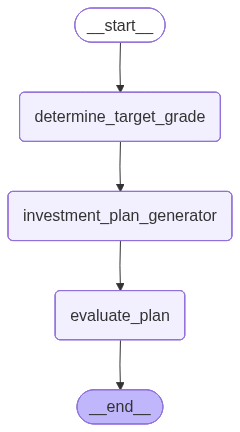

In [45]:
print_workflow_info(optimizer_builder, optimizer_workflow)

## Testing (Reflection)

Test the workflow by invoking it with an example investment profile to see the end-to-end investment plan generation process in action:


In [46]:
# invoke the workflow with an example investor profile
state = optimizer_workflow.invoke({
    "investor_profile": (
        "Age: 29\n"
        "Salary: $110,000\n"
        "Assets: $40,000\n"
        "Goal: Achieve financial independence by age 45\n"
        "Risk tolerance: High"
    )
})

Trace(trace_id=tr-436505e92541ed78169d1734172e6d97)

In [47]:
def pretty_print_final_state(state: dict):
    print("🎯 Final Investment Plan Summary\n" + "="*40)
    print(f"\n📌 Investor Profile:\n{state['investor_profile']}")
    
    print("\n📈 Target Risk Grade:", state['target_grade'])
    print("📊 Final Assigned Grade:", state['grade'])
    print("🔁 Iterations Taken:", state['n'])

    print("\n📝 Evaluator Feedback:\n" + "-"*30)
    print(state['feedback'])

    print("\n📃 Final Investment Plan:\n" + "-"*30)
    print(state['investment_plan'])

pretty_print_final_state(state)

🎯 Final Investment Plan Summary

📌 Investor Profile:
Age: 29
Salary: $110,000
Assets: $40,000
Goal: Achieve financial independence by age 45
Risk tolerance: High

📈 Target Risk Grade: high risk
📊 Final Assigned Grade: high risk
🔁 Iterations Taken: 1

📝 Evaluator Feedback:
------------------------------
The proposed investment strategy appears to be speculative and high-risk. The focus on emerging technologies such as AI, biotechnology, blockchain, and renewable energy raises concerns about market volatility and potential for significant losses. While the investor has a high risk tolerance, this strategy may not align with conservative principles of capital preservation and long-term stability. It is essential to carefully evaluate the underlying assets and consider alternative investment strategies that prioritize sound fundamentals and diversified portfolios.

📃 Final Investment Plan:
------------------------------
As an investor at the ripe old age of 29 with a substantial retirement